In [1]:
#This code imports packages that will be used later on, allowing us to use SeQUeNCe's modules and capabilities

#Import the Node and BSMNode classes, which we will use as the basis for our player's circuits and referees circuit, respectively
from sequence.topology.node import Node, BSMNode

#Import the Memory class, which we will use to hold our qubits
from sequence.components.memory import Memory

#Import the EntanglementGenerationA class, which we will use to entangle our player's qubits
from sequence.entanglement_management.generation import EntanglementGenerationA

#Import the Timeline class, which will allow our simulation to run
from sequence.kernel.timeline import Timeline

#Import the QuantumChannel and ClassicalChannel classes, which allow for communication between Alice and Bob and the referee
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel

#Import the EntanglementProtocol class, which manages the processes of creating entanglement
from sequence.entanglement_management.entanglement_protocol import EntanglementProtocol

#Import the Message class, which enables communication on classical channels
from sequence.message import Message

#Import the Circuit class, which we will use to build custom circuits
from sequence.components.circuit import Circuit, x_gate, y_gate, z_gate, s_gate, t_gate, validator

#Import the Protocol class, which allows us to define custom actions for nodes
from sequence.protocol import Protocol

#Import the QuantumManager class
from sequence.kernel import quantum_manager

#Import relevant components from Qutip, a quantum system simulator that SeQUeNCe incorporates
from qutip.qip.circuit import QubitCircuit, CircuitSimulator
from qutip.qip.operations import gate_sequence_product
from qutip import Qobj

#Import other helpful python libraries
import numpy as np
from enum import Enum
import random
import math

C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\qutip\__init__.py:71: UserWarning: Runtime cython compilation does not work on Python 3.12.
  warnings.warn(


In [2]:
# This code defines hardware we need to run our simulation

# Define the custom gates that Bob will apply to his qubit

def gate_0():
    angle_0 = np.pi/8
    mat = np.array([[np.cos(angle_0), np.sin(angle_0)], 
                    [np.sin(angle_0), -np.cos(angle_0)]])
    return Qobj(mat, dims = [[2], [2]])

def gate_1():
    angle_1 = -np.pi/8
    mat = np.array([[np.cos(angle_1), np.sin(angle_1)], 
                    [np.sin(angle_1), -np.cos(angle_1)]])
    return Qobj(mat, dims = [[2], [2]])

# Define a CustomCircuit class so we can calculate the unitary matrix of our circuits
# The only difference from SeQUeNCe's built-in Circuit class is the addition of our custom gates

class CustomCircuit(Circuit):
    def __init__(self, size: int):
        super().__init__(size)
        
    def get_unitary_matrix(self) -> np.ndarray:
        if self._cache is None:
            if len(self.gates) == 0:
                self._cache = np.identity(2 ** self.size)
                return self._cache

            qc = QubitCircuit(self.size)
            qc.user_gates = {"X": x_gate,
                             "Y": y_gate,
                             "Z": z_gate,
                             "S": s_gate,
                             "T": t_gate,
                             "0": gate_0,
                             "1": gate_1}
            for gate in self.gates:
                name, indices, arg = gate
                if name == 'h':
                    qc.add_gate('SNOT', indices[0])
                elif name == 'x':
                    qc.add_gate('X', indices[0])
                elif name == 'y':
                    qc.add_gate('Y', indices[0])
                elif name == 'z':
                    qc.add_gate('Z', indices[0])
                elif name == 'cx':
                    qc.add_gate('CNOT', controls=indices[0], targets=indices[1])
                elif name == 'ccx':
                    qc.add_gate('TOFFOLI', controls=indices[:2], targets=indices[2])
                elif name == 'swap':
                    qc.add_gate('SWAP', indices)
                elif name == 't':
                    qc.add_gate('T', indices[0])
                elif name == 's':
                    qc.add_gate('S', indices[0])
                elif name == 'phase':
                    qc.add_gate('PHASEGATE', indices[0], arg_value=arg)
                elif name == '0_gate':
                    qc.add_gate('0', indices[0])
                elif name == '1_gate':
                    qc.add_gate('1', indices[0])
                else:
                    raise NotImplementedError
            self._cache = gate_sequence_product(qc.propagators()).full()

        return self._cache

# Define a manager to update protocols on the player's nodes
class Manager:
    def __init__(self, node, mem_name):
        self.node = node
        self.mem_name = mem_name
        
    def update(self, prot, mem, st):
        if st == 'RAW':
            mem.reset()
    
    def add_entanglement_protocol(self, middle: str, other: str):
        self.node.protocols = [EntanglementGenerationA(self.node, '%s.eg' % self.node.name, 
                                                       middle, other, self.node.components[self.mem_name])]
        
    def add_player_protocol(self, rec_name: str, rec_node: str):
        PlayerProtocol(self.node, '%s.pp' % self.node.name, rec_name, rec_node)
    
    def add_alice_protocol(self):
        AliceProtocol(self.node, '%s.ap' % self.node.name)
        
    def add_bob_protocol(self):
        BobProtocol(self.node, '%s.bp' % self.node.name)
    
# Define a custom PlayerNode class, with a manager instance variable
class PlayerNode(Node):
    def __init__(self, name: str, tl: Timeline, circ: CustomCircuit, reg: int, fid: int = 1, eff: int = 1):
        super().__init__(name, tl)
        
        mem_name = '%s.mem' % name
        mem = Memory(mem_name, tl, fidelity = fid, frequency = 20e3,
                    efficiency = eff, coherence_time = 0, wavelength = 1000) #CHECK COHERENCE TIME
        mem.owner = self
        mem.add_receiver(self)
        self.add_component(mem)
        self.resource_manager = Manager(self, mem_name)
        self.shared_circ = circ
        assert reg < circ.size, "register can't be bigger than the number of qubits"
        self.reg = reg
                
    def init(self):
        mem = self.get_components_by_type('Memory')[0]
        mem.reset()
        
    def receive_msg(self, src: str, msg: 'Message'):
        self.protocols[0].received_message(src, msg)
    
    def get(self, photon, **kwargs):
        self.send_qubit(kwargs['dst'], photon)

In [12]:
# This code defines custom protocols we need to run our simulation

# Define a method to pair entanglement protocols between the two players
def pair_protocol(node1: Node, node2: Node):
    p1 = node1.protocols[0]
    p2 = node2.protocols[0]
    n1_mem_name = node1.get_components_by_type('Memory')[0].name
    n2_mem_name = node2.get_components_by_type('Memory')[0].name
    p1.set_others(p2.name, node2.name, [n2_mem_name])
    p2.set_others(p1.name, node1.name, [n1_mem_name])
    
# Define a function to add and pair entanglement protocols on both player's nodes
def generate_entanglement(node1: Node, node2: Node, entangler: Node):
    node1.resource_manager.add_entanglement_protocol(entangler.name, node2.name)
    node2.resource_manager.add_entanglement_protocol(entangler.name, node1.name)
    pair_protocol(node1, node2)

#  \Define custom enumerators to enable sending custom messages with SeQUeNCe's message package
class MsgType(Enum):
    ZERO = 0
    ONE = 1
    READY = 2
    
class Player(Enum):
    ALICE = 0
    BOB = 1

# Define a function to get the node a name refers to (for convenience)
def getNodeFromName(name: str, nodes: list[Node]):
    for node in nodes:
        if node.name == name:
            return node
    
    print("Node not found. Returning NoneType")
    return None

# Define custom protocols that define all three participants' behavior when the game starts
class RefereeProtocol(Protocol):
    def __init__(self, own: Node, name: str, tl: Timeline, players: list[Node], eff: int = 1, debug: bool = False, ge: bool = False):
        super().__init__(own, name)
        self.own = own.protocols.append(self)
        self.tl = tl
        self.players = players
        self.inputs = []
        self.msgs_rec = 0
        self.keys = []
        self.result = None
        self.eff = eff
        self.debug = debug
        self.guar_ent = ge
        
    def init(self):
        pass
    
    # Define a function to generate a random input (0 or 1) and send it to a player
    def sendBit(self, player_prot: str, player_node: str):
        bit = random.randint(0, 1)
        self.inputs.append(bit)
        msg = Message(MsgType(bit), player_prot)
        self.own.send_message(player_node, msg)
    
    # Define a function to handle player's responses
    def received_message(self, src: str, msg: Message):      
        self.msgs_rec += 1
        
        src_node = getNodeFromName(src, self.players)
        key = src_node.get_components_by_type('Memory')[0].qstate_key
        self.keys.append(key)
        circ = src_node.shared_circ
        
        #If both players have responded, the referee runs their circuit and measures their qubits
        if (self.msgs_rec == 2):   
            if (self.guar_ent):
                assert src_node.get_components_by_type('Memory')[0].entangled_memory['node_id'] != None, 'Entanglement generation failed'
            
            circ.measure(0)
            circ.measure(1)
            res = self.tl.quantum_manager.run_circuit(circ, self.keys, random.random())
            self.adjudicate_round(self.inputs, res)
            
    # Define a function to check if player responses met their win condition, return a win if so
    def adjudicate_round(self, inp: list[int], res: dict[int, int]):       
        # Simulate noise in detector measurement
        if (random.random() > self.eff):           
            if self.debug:
                print('Alice\'s qubit, which was', res[0], ', was measured as 0.')    
            res[0] = 0
            
        if (random.random() > self.eff):
            if self.debug:
                print('Bob\'s qubit, which was', res[1], ', was measured as 0.')  
            res[1] = 0
        
        a_inp = inp[0]
        b_inp = inp[1]
        a_res = res[0]
        b_res = res[1]
        
        if ((a_res + b_res) % 2 == a_inp * b_inp):
            if self.debug:
                print('WIN! Inputs:', inp, 'Outputs:', res)
            self.result = True
        else:
            if self.debug:
                print('LOSS. Inputs:', inp, 'Outputs:', res)
            self.result = False
                
    # Define a getter function for other classes to get the result
    def get_result(self):
        assert self.result is not None, 'Result was NoneType. Has the game finished?'
        return self.result
    
class PlayerProtocol(Protocol):
    def __init__(self, own: Node, name: str, rec_name: str, rec_node: str):
        super().__init__(own, name)
        self.rec_name = rec_name
        self.rec_node = rec_node
        own.protocols.append(self)
    
    def init(self):
        pass
    
    # Define a method to get an input from the referee, add the appropriate gates to the circuit,
    # Then signal to the referee that the player is ready
    def received_message(self, src: str, msg: Message):
        self.own.protocols[1].applyGate(msg)
        return_msg = Message(MsgType(2), self.rec_name)
        self.own.send_message(self.rec_node, return_msg)
        
class AliceProtocol(Protocol):
    def __init__(self, own: Node, name: str):
        super().__init__(own, name)
        own.protocols.append(self)
        
    def init(self):
        pass
        
    # Define a function that decides whether to apply a gate based on Alice's strategy
    def applyGate(self, in_bit: Message):
        # Apply Hadamard gate if input = 1, otherwise do nothing
        if (in_bit.msg_type == MsgType.ONE):
            self.own.shared_circ.gates.append(['h', [self.own.reg], None])
                
    def received_message(self, src: str, msg: Message):
        pass
        
class BobProtocol(Protocol):    
    def __init__(self, own: Node, name: str):
        super().__init__(own, name)
        own.protocols.append(self)
        
    def init(self):
        pass
            
    # Define a function that decides which gate to apply based on Bob's strategy
    def applyGate(self, in_bit: Message):
        # Apply the unitary gate that corresponds to the input       
        if (in_bit.msg_type == MsgType.ONE):
            self.own.shared_circ.gates.append(['1_gate', [self.own.reg], None])
        else:
            self.own.shared_circ.gates.append(['0_gate', [self.own.reg], None])
                    
    def received_message(self, src: str, msg: Message):
        pass

In [13]:
# This code creates a Game class to manage the creation and simulation of individual games

class Game:
    
    def __init__(self, debug: bool = False, fid: int = 1, eff: int = 1, guarantee_entanglement: bool = True):
        self.games = 100
        self.wins = 0
        self.debug = debug
        self.fidelity = fid
        self.efficiency = eff
        self.guar_ent = guarantee_entanglement
        
        if (not self.guar_ent):
            self.successful_entanglements = 0
        
    def setup(self):
        # Create the timeline for the simulation
        self.tl = Timeline()

        # Create a circuit for Alice and Bob to share
        self.shared_circ = CustomCircuit(2)

        # Create nodes for Alice, Bob, and a Bell State Management Node to generate entanglement
        self.a = PlayerNode('a', self.tl, self.shared_circ, 0, fid = self.fidelity)
        self.b = PlayerNode('b', self.tl, self.shared_circ, 1, fid = self.fidelity)

        # The referee's channel uses SeQUeNCe's built-in BSMNode
        self.ent_node = BSMNode('ent_node', self.tl, ['a', 'b'])

        # Set the efficiency of the BSM to 1, which means no errors
        self.bsm = self.ent_node.get_components_by_type('SingleAtomBSM')[0]
        self.bsm.update_detectors_params('efficiency', 1)

        # Create a node for the referee to get and receive bits
        self.r = Node('ref', self.tl)
        self.nodes = [self.a, self.b, self.ent_node, self.r]

        # Create quantum channels between Alice and Bob and the ref
        self.qcA = QuantumChannel('qcA', self.tl, attenuation = 0, distance = 1000)
        self.qcB = QuantumChannel('qcB', self.tl, attenuation = 0, distance = 1000)
        self.qcA.set_ends(self.a, self.ent_node.name)
        self.qcB.set_ends(self.b, self.ent_node.name)

        # Create classical channels between all existing nodes
        # Classical channels are one way only, so we have to make two channels for each connection
        for i in range (len(self.nodes)):
            for j in range(len(self.nodes)):
                if (i != j):
                    cc = ClassicalChannel('cc_%s_%s'%(self.nodes[i].name, self.nodes[j].name), self.tl, 1000, 1e8)
                    cc.set_ends(self.nodes[i], self.nodes[j].name)
    
    # Define a function to simulate the games and print the number won
    def start(self, games: int = 100):
        self.games = games
        
        for i in range(self.games):
            # Create nodes for every player and define entanglement protocol
            self.setup()
            
            # Add and run the entanglement protocol to each player node
            generate_entanglement(self.a, self.b, self.ent_node)
            self.tl.init()
            self.a.protocols[0].start()
            self.b.protocols[0].start()
            self.tl.run()

            mem_a = self.a.get_components_by_type('Memory')[0]
            
            # Keep rerunning the entanglement protocol until entanglement is successfully created
            if (self.guar_ent):
                while (mem_a.entangled_memory['node_id'] == None): 
                    generate_entanglement(self.a, self.b, self.ent_node)
                    self.a.protocols[0].start()
                    self.b.protocols[0].start()
                    self.tl.run()
            else:
                if (self.a.get_components_by_type('Memory')[0].entangled_memory['node_id'] != None):
                    self.successful_entanglements += 1
            
            # Play a round and store the result in a variable
            rnd = self.play_round()
            
            # If the result is a win, add one to the win counter
            if rnd:
                self.wins += 1
        
        if (not self.guar_ent):
            print('Successfully entangled Alice and Bob\'s qubits', self.successful_entanglements, 
                  'out of', self.games, 'games.')
            
        print('Won', self.wins, 'out of', self.games, 'games.')
    
    # Define a function to send input bits to each player and return whether their outputs won the win condition
    def play_round(self):
        # Reset all participants' protocols
        self.preset()
        
        # Add protocols for each node to assign their behavior
        self.a.resource_manager.add_player_protocol('prot_r', 'ref')
        self.a.resource_manager.add_alice_protocol()
        self.b.resource_manager.add_player_protocol('prot_r', 'ref')
        self.b.resource_manager.add_bob_protocol()
        
        # Add protocol to the referee to assign their behavior
        prot_r = RefereeProtocol(self.r, 'prot_r', self.tl, [self.a, self.b], eff = self.efficiency, 
                                 debug = self.debug, ge = self.guar_ent)

        # Send bits to both Alice and Bob, who will respond automatically
        self.r.protocols[0].sendBit('a.pp', 'a')
        self.r.protocols[0].sendBit('b.pp', 'b')
        self.tl.run()
        
        #Get whether Alice and Bob won or lost, and return it to the start function
        return prot_r.get_result()
        
    # Define a function to clear player protocols and circuits to ensure the game runs from scratch
    def preset(self):
        self.a.protocols = []
        self.b.protocols = []
        self.r.protocols = []
        self.shared_circ.gates = []
        self.shared_circ.measured_qubits = []

In [14]:
for i in range(10):
    g = Game()
    g.start(100)

AttributeError: 'NoneType' object has no attribute 'send_message'

# Analysis of Different Fidelity Values 

In [17]:
for i in range(10):
    g_low_fidelity = Game(fid = 0.9)
    g_low_fidelity.start(100)

Won 79 out of 100 games.
Won 77 out of 100 games.
Won 77 out of 100 games.
Won 76 out of 100 games.
Won 85 out of 100 games.
Won 79 out of 100 games.
Won 81 out of 100 games.
Won 83 out of 100 games.
Won 84 out of 100 games.
Won 83 out of 100 games.


NameError: name 'avg_wins_b_20' is not defined

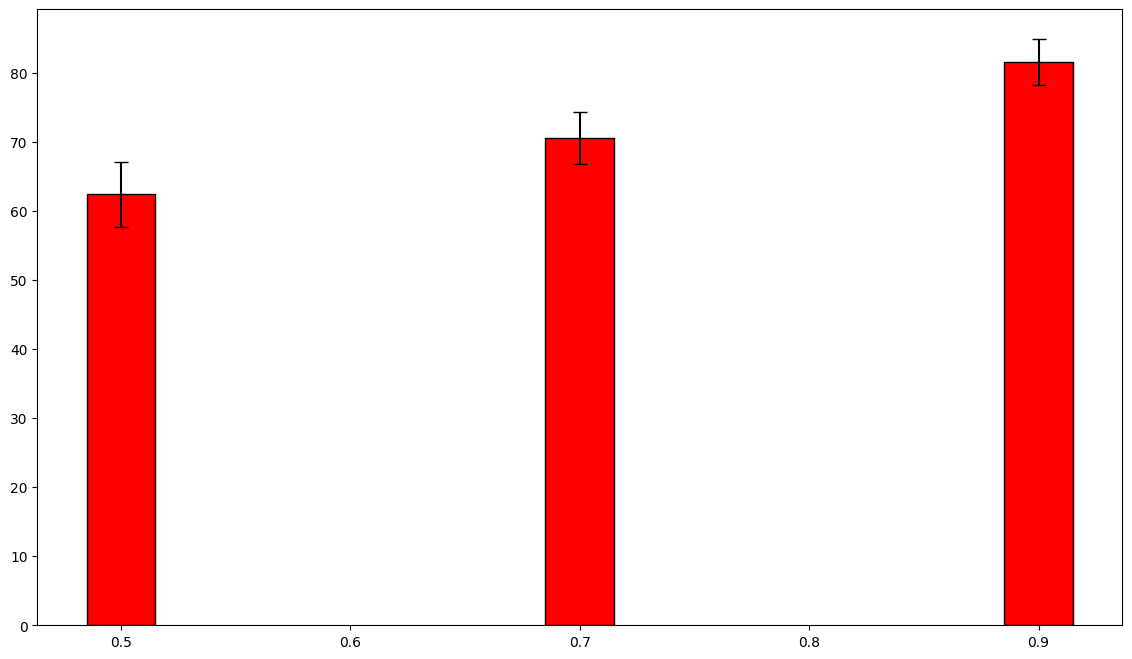

In [25]:
import matplotlib.pyplot as plt

wins_circuit_a_50 = [59, 67, 66, 54, 66, 55, 68, 64, 61, 64]  
wins_circuit_a_70 = [68, 67, 75, 67, 69, 77, 69, 70, 76, 67]  
wins_circuit_a_90 = [81, 75, 82, 80, 80, 87, 86, 79, 84, 82]  



avg_wins_a_20 = np.mean(wins_circuit_a_50)
avg_wins_a_40 = np.mean(wins_circuit_a_70)
avg_wins_a_60 = np.mean(wins_circuit_a_90)


std_wins_a_20 = np.std(wins_circuit_a_50)
std_wins_a_40 = np.std(wins_circuit_a_70)
std_wins_a_60 = np.std(wins_circuit_a_90)


fidelity = [0.5, 0.7, 0.9]

bar_width = 0.03

plt.figure(figsize=(14, 8))

bars_a = plt.bar(np.array(fidelity) , [avg_wins_a_20, avg_wins_a_40, avg_wins_a_60], yerr = [std_wins_a_20, std_wins_a_40, std_wins_a_60], 
        width = bar_width, label = 'Circuit A', color = 'red', edgecolor = 'black', capsize = 5)

bars_b = plt.bar(np.array(fidelity) + bar_width/2, [avg_wins_b_20, avg_wins_b_40, avg_wins_b_60], yerr = [std_wins_b_20, std_wins_b_40, std_wins_b_60], 
       width = bar_width, label = 'Circuit B', color = 'green', edgecolor = 'black', capsize = 5)

plt.xlabel('Fidelity')
plt.ylabel('Average Percentage of Wins')
plt.title('Average Wins vs Frequency of Circuit A for Different Fidelities')
plt.xticks(fidelity, ['0.5', '0.7', '0.9'], ha = 'center')
plt.legend(loc = 'upper right')
for bar in bars_a:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va = 'bottom') 

for bar in bars_b:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  

plt.show()

# Analysis of Different Frequencies for coherence time = -1

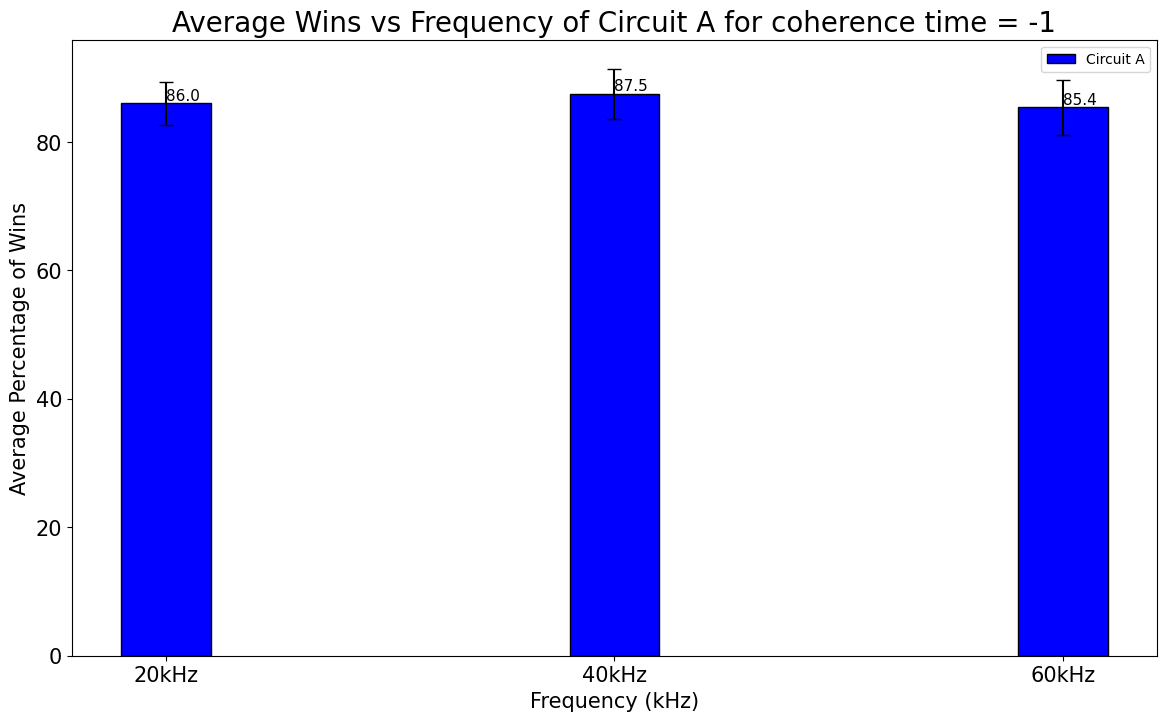

In [1]:
import matplotlib.pyplot as plt
import numpy as np

wins_circuit_a_20 = [82, 86, 83, 90, 86, 84, 84, 83, 89, 93]  
wins_circuit_a_40 = [80, 83, 91, 91, 90, 90, 83, 89, 87, 91]  
wins_circuit_a_60 = [82, 86, 90, 77, 86, 84, 84, 83, 89, 93]  

wins_circuit_b_20 = [72, 70, 69, 78, 78, 83, 76, 73, 78, 66]  
wins_circuit_b_40 = [78, 76, 73, 77, 76, 71, 71, 76, 71, 72]  
wins_circuit_b_60 = [79, 72, 68, 81, 69, 78, 79, 71, 77, 70]  

avg_wins_a_20 = np.mean(wins_circuit_a_20)
avg_wins_a_40 = np.mean(wins_circuit_a_40)
avg_wins_a_60 = np.mean(wins_circuit_a_60)

avg_wins_b_20 = np.mean(wins_circuit_b_20)
avg_wins_b_40 = np.mean(wins_circuit_b_40)
avg_wins_b_60 = np.mean(wins_circuit_b_60)

std_wins_a_20 = np.std(wins_circuit_a_20)
std_wins_a_40 = np.std(wins_circuit_a_40)
std_wins_a_60 = np.std(wins_circuit_a_60)

std_wins_b_20 = np.std(wins_circuit_b_20)
std_wins_b_40 = np.std(wins_circuit_b_40)
std_wins_b_60 = np.std(wins_circuit_b_60)

freq = [20e3, 40e3, 60e3]

bar_width = 4e3  

plt.figure(figsize=(14, 8))

bars_a = plt.bar(np.array(freq) , [avg_wins_a_20, avg_wins_a_40, avg_wins_a_60], yerr = [std_wins_a_20, std_wins_a_40, std_wins_a_60], 
        width = bar_width, label = 'Circuit A', color = 'blue', edgecolor = 'black', capsize = 5)

#bars_b = plt.bar(np.array(freq) + bar_width/2, [avg_wins_b_20, avg_wins_b_40, avg_wins_b_60], yerr = [std_wins_b_20, std_wins_b_40, std_wins_b_60], 
       #width = bar_width, label = 'Circuit B', color = 'green', edgecolor = 'black', capsize = 5)

plt.xlabel('Frequency (kHz)', fontsize = 15)
plt.ylabel('Average Percentage of Wins', fontsize = 15)
plt.title('Average Wins vs Frequency of Circuit A for coherence time = -1', fontsize = 20)
plt.xticks(freq, ['20kHz', '40kHz', '60kHz'], ha = 'center', fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 10)
for bar in bars_a:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va = 'bottom', fontsize = 11) 

#for bar in bars_b:
    #yval = bar.get_height()
   # plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  

plt.show()

# Analysis of Different Frequencies for coherence time = 0

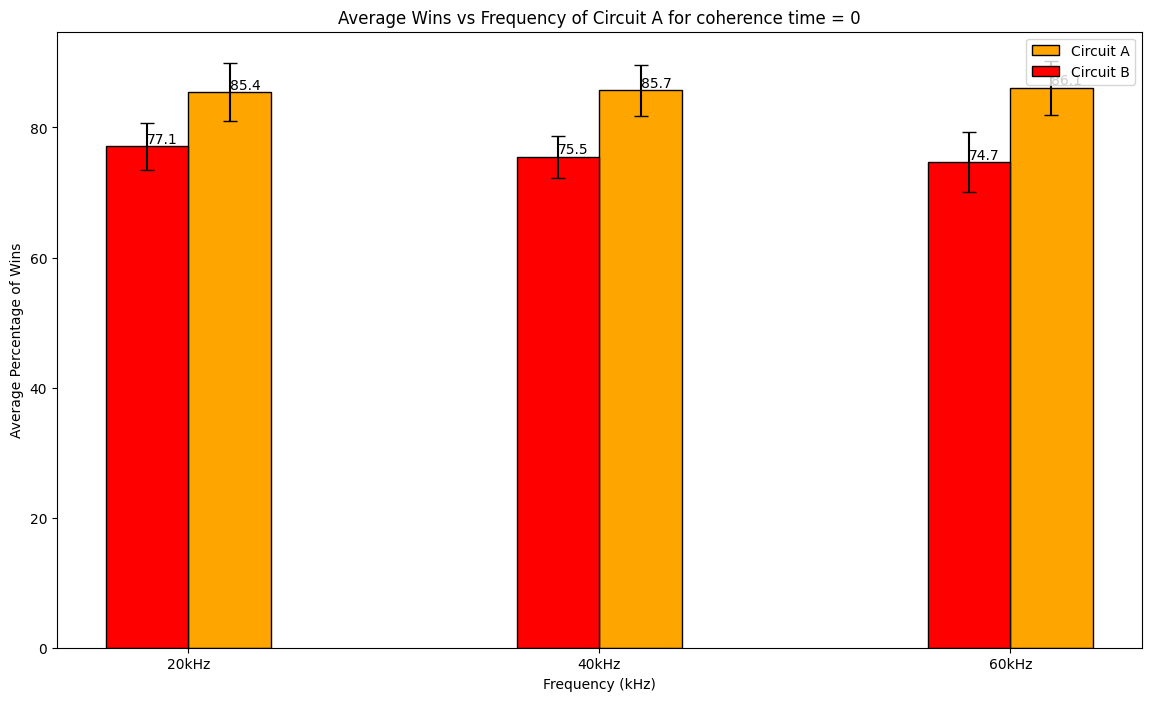

In [13]:
import matplotlib.pyplot as plt

wins_circuit_a_20 = [85, 92, 92, 85, 79, 84, 91, 82, 81, 83]  
wins_circuit_a_40 = [91, 90, 79, 82, 89, 87, 80, 86, 87, 86]  
wins_circuit_a_60 = [82, 95, 81, 81, 84, 88, 86, 88, 87, 89]  

wins_circuit_b_20 = [77, 74, 77, 77, 73, 78, 77, 72, 81, 85]  
wins_circuit_b_40 = [79, 71, 74, 76, 73, 78, 72, 73, 81, 78]  
wins_circuit_b_60 = [67, 69, 70, 78, 81, 73, 76, 79, 74, 80]  

avg_wins_a_20 = np.mean(wins_circuit_a_20)
avg_wins_a_40 = np.mean(wins_circuit_a_40)
avg_wins_a_60 = np.mean(wins_circuit_a_60)

avg_wins_b_20 = np.mean(wins_circuit_b_20)
avg_wins_b_40 = np.mean(wins_circuit_b_40)
avg_wins_b_60 = np.mean(wins_circuit_b_60)

std_wins_a_20 = np.std(wins_circuit_a_20)
std_wins_a_40 = np.std(wins_circuit_a_40)
std_wins_a_60 = np.std(wins_circuit_a_60)

std_wins_b_20 = np.std(wins_circuit_b_20)
std_wins_b_40 = np.std(wins_circuit_b_40)
std_wins_b_60 = np.std(wins_circuit_b_60)

freq = [20e3, 40e3, 60e3]

bar_width = 4e3  

plt.figure(figsize=(14, 8))

bars_a = plt.bar(np.array(freq) + bar_width/2, [avg_wins_a_20, avg_wins_a_40, avg_wins_a_60], yerr = [std_wins_a_20, std_wins_a_40, std_wins_a_60], 
        width = bar_width, label = 'Circuit A', color = 'orange', edgecolor = 'black', capsize = 5)

bars_b = plt.bar(np.array(freq) - bar_width/2, [avg_wins_b_20, avg_wins_b_40, avg_wins_b_60], yerr = [std_wins_b_20, std_wins_b_40, std_wins_b_60], 
                 width = bar_width, label = 'Circuit B', color = 'red', edgecolor = 'black', capsize = 5)

plt.xlabel('Frequency (kHz)')
plt.ylabel('Average Percentage of Wins')
plt.title('Average Wins vs Frequency of Circuit A for coherence time = 0')
plt.xticks(freq, ['20kHz', '40kHz', '60kHz'])
plt.legend(loc = 'upper right')
for bar in bars_a:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom') 

for bar in bars_b:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  

plt.show()

# Analysis of Different Wavelengths while keeping the frequency constant at 20kHz and coherent time at 0

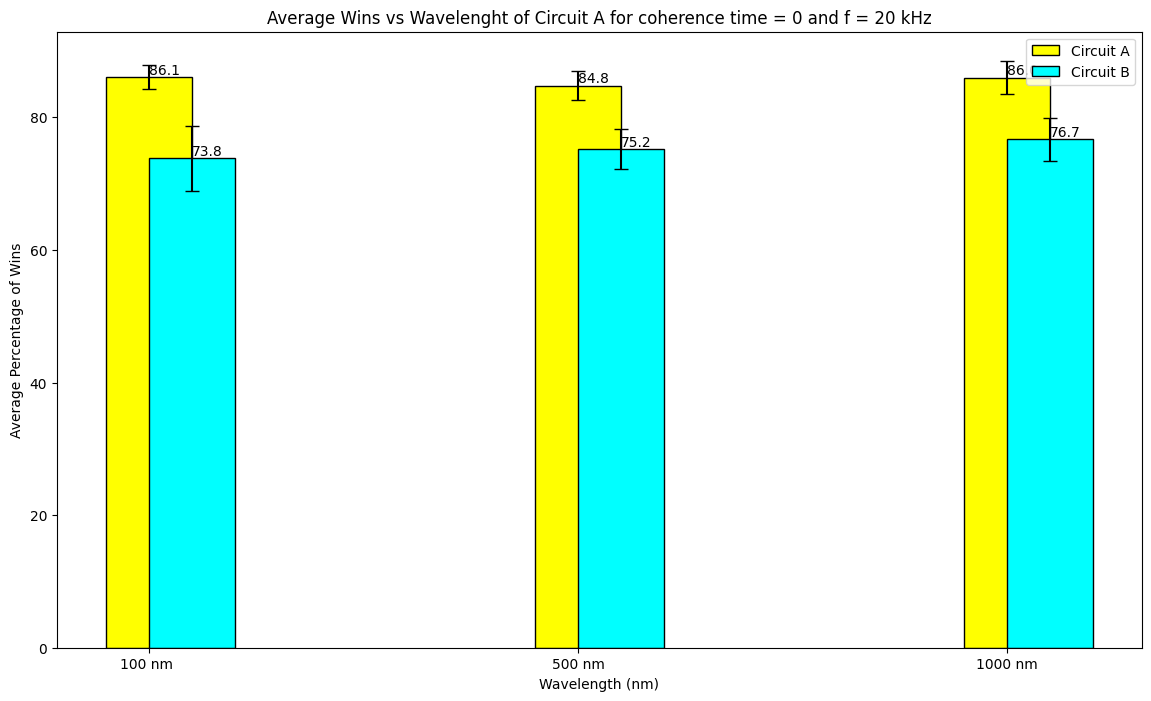

In [7]:

import numpy as np 
import matplotlib.pyplot as plt

wins_circuit_a_100 = [87, 87, 88, 88, 83, 85, 86, 83, 87, 87]  
wins_circuit_a_500 = [82, 84, 89, 84, 84, 83, 85, 88, 86, 83]  
wins_circuit_a_1000 = [84, 91, 82, 87, 88, 86, 86, 88, 84, 84]  

wins_circuit_b_100 = [75, 81, 64, 70, 82, 74, 73, 72, 75, 72]  
wins_circuit_b_500 = [73, 77, 79, 75, 79, 75, 74, 68, 75, 77]  
wins_circuit_b_1000 = [82, 76, 76, 74, 73, 80, 80, 77, 71, 78]  

avg_wins_a_100 = np.mean(wins_circuit_a_100)
avg_wins_a_500 = np.mean(wins_circuit_a_500)
avg_wins_a_1000 = np.mean(wins_circuit_a_1000)

avg_wins_b_100 = np.mean(wins_circuit_b_100)
avg_wins_b_500 = np.mean(wins_circuit_b_500)
avg_wins_b_1000 = np.mean(wins_circuit_b_1000)

std_wins_a_100 = np.std(wins_circuit_a_100)
std_wins_a_500 = np.std(wins_circuit_a_500)
std_wins_a_1000 = np.std(wins_circuit_a_1000)

std_wins_b_100 = np.std(wins_circuit_b_100)
std_wins_b_500 = np.std(wins_circuit_b_500)
std_wins_b_1000 = np.std(wins_circuit_b_1000)

freq = [20e3, 40e3, 60e3]

bar_width = 4e3  

plt.figure(figsize=(14, 8))

bars_a = plt.bar(np.array(freq), [avg_wins_a_100, avg_wins_a_500, avg_wins_a_1000], yerr = [std_wins_a_100, std_wins_a_500, std_wins_a_1000], 
        width = bar_width, label = 'Circuit A', color = 'yellow', edgecolor = 'black', capsize = 5)

bars_b = plt.bar(np.array(freq) + bar_width/2, [avg_wins_b_100, avg_wins_b_500, avg_wins_b_1000], yerr = [std_wins_b_100, std_wins_b_500, std_wins_b_1000], 
       width = bar_width, label = 'Circuit B', color = 'cyan', edgecolor = 'black', capsize = 5)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Average Percentage of Wins')
plt.title('Average Wins vs Wavelenght of Circuit A for coherence time = 0 and f = 20 kHz')
plt.xticks(freq, ['100 nm ', '500 nm', '1000 nm'])
plt.legend(loc = 'upper right')
for bar in bars_a:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom') 

for bar in bars_b:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  

plt.show()

In [30]:
for i in range(1000):
    results = []
    g = Game()
    results.append((g.start(i)))

Won 0 out of 0 games.
Won 1 out of 1 games.
Won 2 out of 2 games.
Won 2 out of 3 games.
Won 4 out of 4 games.
Won 5 out of 5 games.
Won 5 out of 6 games.
Won 7 out of 7 games.
Won 7 out of 8 games.
Won 7 out of 9 games.
Won 9 out of 10 games.
Won 10 out of 11 games.
Won 10 out of 12 games.
Won 11 out of 13 games.
Won 12 out of 14 games.
Won 14 out of 15 games.
Won 14 out of 16 games.
Won 15 out of 17 games.
Won 17 out of 18 games.
Won 18 out of 19 games.
Won 15 out of 20 games.
Won 17 out of 21 games.
Won 17 out of 22 games.
Won 19 out of 23 games.
Won 20 out of 24 games.
Won 24 out of 25 games.
Won 20 out of 26 games.
Won 25 out of 27 games.
Won 27 out of 28 games.
Won 25 out of 29 games.
Won 26 out of 30 games.
Won 28 out of 31 games.
Won 26 out of 32 games.
Won 28 out of 33 games.
Won 31 out of 34 games.
Won 29 out of 35 games.
Won 29 out of 36 games.
Won 34 out of 37 games.
Won 30 out of 38 games.
Won 35 out of 39 games.
Won 34 out of 40 games.
Won 29 out of 41 games.
Won 34 out of

Won 276 out of 325 games.
Won 280 out of 326 games.
Won 281 out of 327 games.
Won 282 out of 328 games.
Won 283 out of 329 games.
Won 281 out of 330 games.
Won 285 out of 331 games.
Won 284 out of 332 games.
Won 275 out of 333 games.
Won 285 out of 334 games.
Won 289 out of 335 games.
Won 283 out of 336 games.
Won 292 out of 337 games.
Won 289 out of 338 games.
Won 295 out of 339 games.
Won 287 out of 340 games.
Won 272 out of 341 games.
Won 289 out of 342 games.
Won 296 out of 343 games.
Won 292 out of 344 games.
Won 290 out of 345 games.
Won 288 out of 346 games.
Won 301 out of 347 games.
Won 305 out of 348 games.
Won 293 out of 349 games.
Won 289 out of 350 games.
Won 289 out of 351 games.
Won 295 out of 352 games.
Won 288 out of 353 games.
Won 311 out of 354 games.
Won 299 out of 355 games.
Won 303 out of 356 games.
Won 310 out of 357 games.
Won 306 out of 358 games.
Won 308 out of 359 games.
Won 307 out of 360 games.
Won 312 out of 361 games.
Won 306 out of 362 games.
Won 311 out 

Won 544 out of 641 games.
Won 558 out of 642 games.
Won 539 out of 643 games.
Won 561 out of 644 games.
Won 556 out of 645 games.
Won 565 out of 646 games.
Won 552 out of 647 games.
Won 546 out of 648 games.
Won 550 out of 649 games.
Won 560 out of 650 games.
Won 559 out of 651 games.
Won 562 out of 652 games.
Won 544 out of 653 games.
Won 560 out of 654 games.
Won 562 out of 655 games.
Won 554 out of 656 games.
Won 565 out of 657 games.
Won 556 out of 658 games.
Won 563 out of 659 games.
Won 554 out of 660 games.
Won 563 out of 661 games.
Won 569 out of 662 games.
Won 558 out of 663 games.
Won 580 out of 664 games.
Won 553 out of 665 games.
Won 550 out of 666 games.
Won 558 out of 667 games.
Won 573 out of 668 games.
Won 570 out of 669 games.
Won 569 out of 670 games.
Won 573 out of 671 games.
Won 573 out of 672 games.
Won 591 out of 673 games.
Won 577 out of 674 games.
Won 570 out of 675 games.
Won 580 out of 676 games.
Won 585 out of 677 games.
Won 584 out of 678 games.
Won 575 out 

Won 811 out of 957 games.
Won 814 out of 958 games.
Won 813 out of 959 games.
Won 828 out of 960 games.
Won 811 out of 961 games.
Won 818 out of 962 games.
Won 834 out of 963 games.
Won 838 out of 964 games.
Won 824 out of 965 games.
Won 821 out of 966 games.
Won 835 out of 967 games.
Won 793 out of 968 games.
Won 818 out of 969 games.
Won 843 out of 970 games.
Won 817 out of 971 games.
Won 834 out of 972 games.
Won 821 out of 973 games.
Won 828 out of 974 games.
Won 836 out of 975 games.
Won 840 out of 976 games.
Won 835 out of 977 games.
Won 849 out of 978 games.
Won 835 out of 979 games.
Won 825 out of 980 games.
Won 850 out of 981 games.
Won 822 out of 982 games.
Won 847 out of 983 games.
Won 855 out of 984 games.
Won 826 out of 985 games.
Won 853 out of 986 games.
Won 834 out of 987 games.
Won 851 out of 988 games.
Won 866 out of 989 games.
Won 843 out of 990 games.
Won 841 out of 991 games.
Won 829 out of 992 games.
Won 854 out of 993 games.
Won 847 out of 994 games.
Won 845 out 

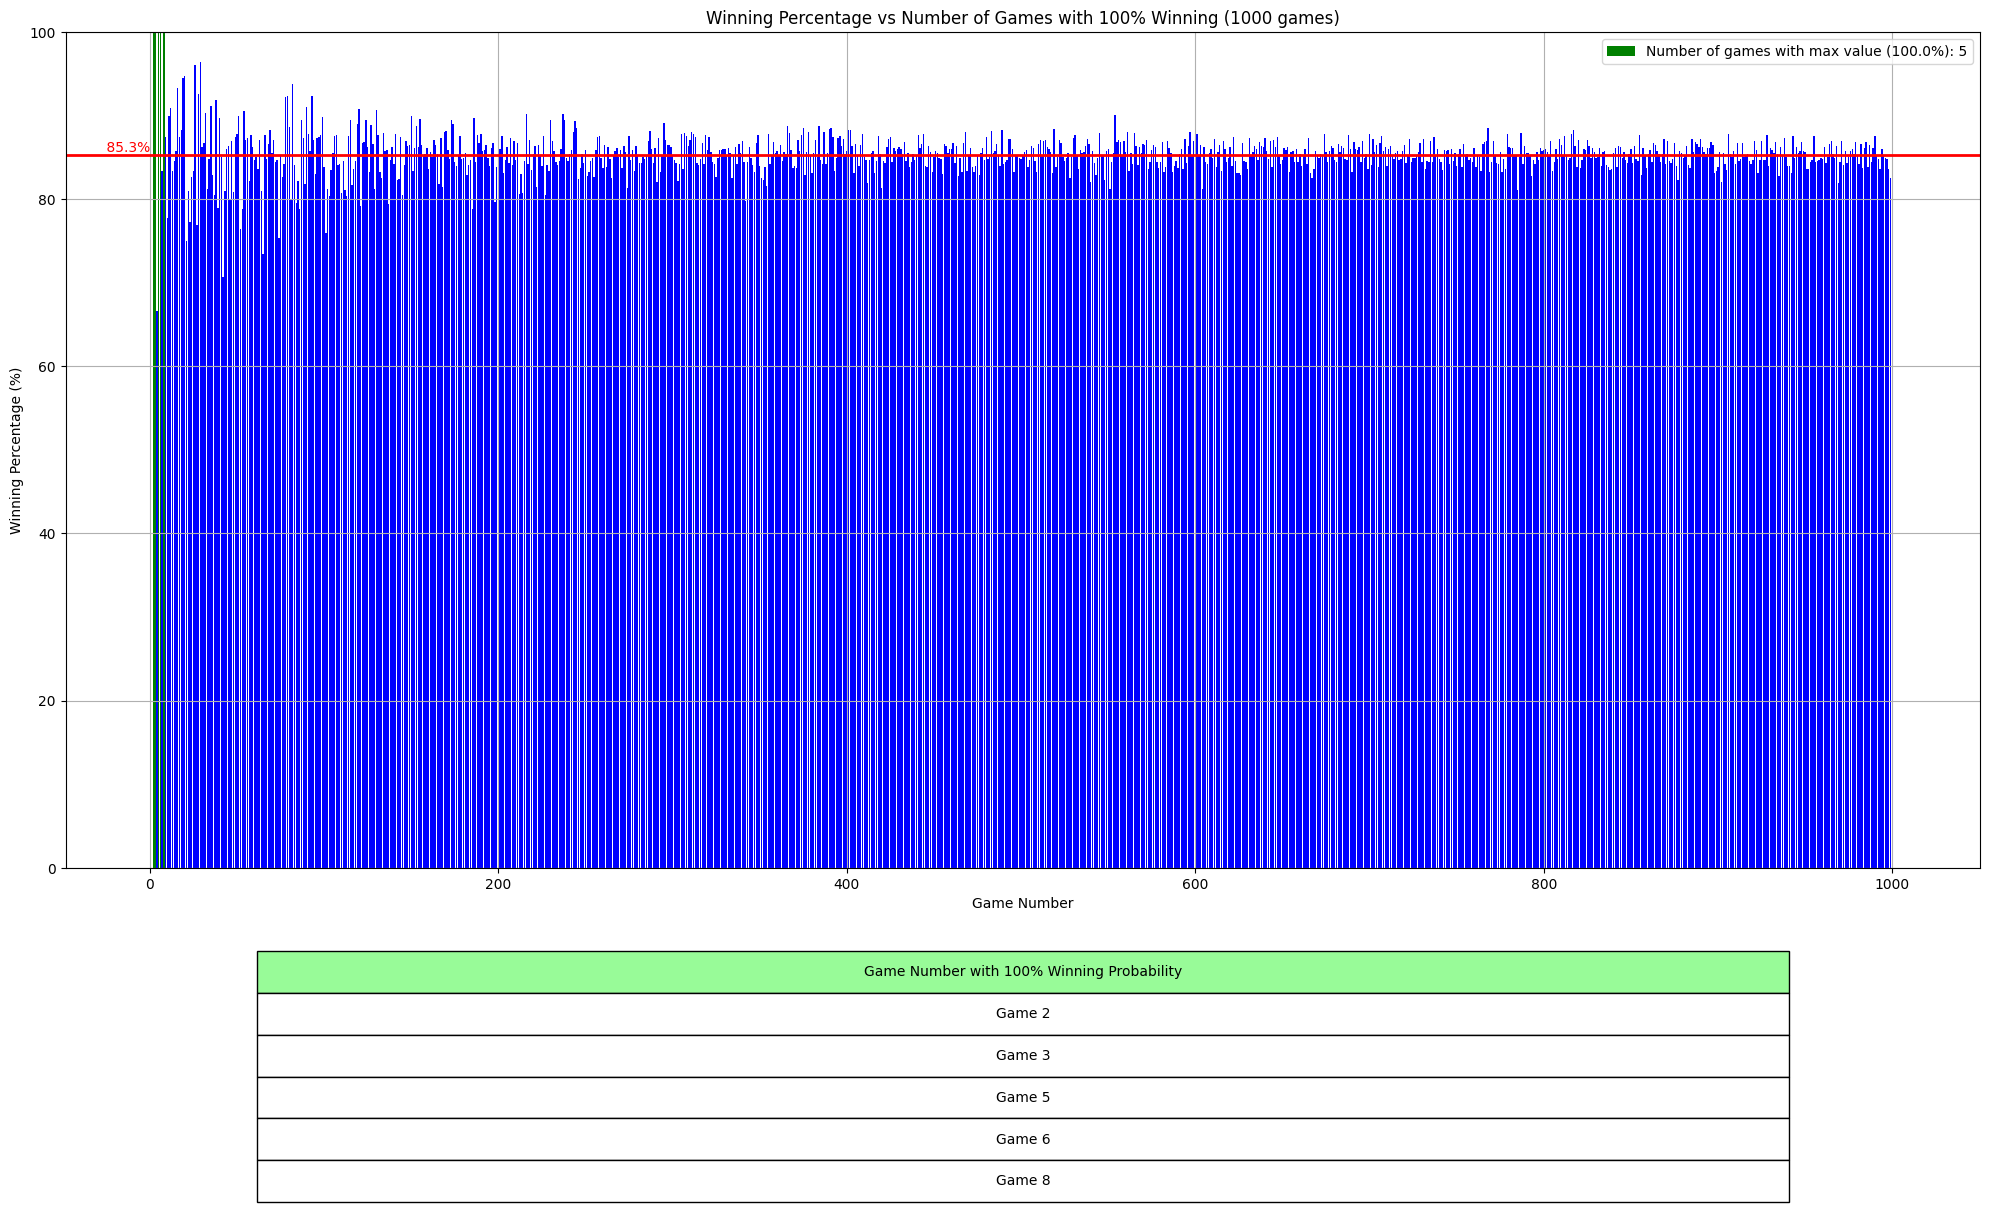

In [6]:
import re
import matplotlib.pyplot as plt

# The provided text
text = """
Won 0 out of 0 games.
Won 1 out of 1 games.
Won 2 out of 2 games.
Won 2 out of 3 games.
Won 4 out of 4 games.
Won 5 out of 5 games.
Won 5 out of 6 games.
Won 7 out of 7 games.
Won 7 out of 8 games.
Won 7 out of 9 games.
Won 9 out of 10 games.
Won 10 out of 11 games.
Won 10 out of 12 games.
Won 11 out of 13 games.
Won 12 out of 14 games.
Won 14 out of 15 games.
Won 14 out of 16 games.
Won 15 out of 17 games.
Won 17 out of 18 games.
Won 18 out of 19 games.
Won 15 out of 20 games.
Won 17 out of 21 games.
Won 17 out of 22 games.
Won 19 out of 23 games.
Won 20 out of 24 games.
Won 24 out of 25 games.
Won 20 out of 26 games.
Won 25 out of 27 games.
Won 27 out of 28 games.
Won 25 out of 29 games.
Won 26 out of 30 games.
Won 28 out of 31 games.
Won 26 out of 32 games.
Won 28 out of 33 games.
Won 31 out of 34 games.
Won 29 out of 35 games.
Won 29 out of 36 games.
Won 34 out of 37 games.
Won 30 out of 38 games.
Won 35 out of 39 games.
Won 34 out of 40 games.
Won 29 out of 41 games.
Won 34 out of 42 games.
Won 37 out of 43 games.
Won 38 out of 44 games.
Won 36 out of 45 games.
Won 40 out of 46 games.
Won 38 out of 47 games.
Won 42 out of 48 games.
Won 43 out of 49 games.
Won 45 out of 50 games.
Won 39 out of 51 games.
Won 41 out of 52 games.
Won 48 out of 53 games.
Won 47 out of 54 games.
Won 48 out of 55 games.
Won 46 out of 56 games.
Won 50 out of 57 games.
Won 50 out of 58 games.
Won 50 out of 59 games.
Won 51 out of 60 games.
Won 51 out of 61 games.
Won 54 out of 62 games.
Won 51 out of 63 games.
Won 47 out of 64 games.
Won 57 out of 65 games.
Won 56 out of 66 games.
Won 58 out of 67 games.
Won 60 out of 68 games.
Won 59 out of 69 games.
Won 61 out of 70 games.
Won 60 out of 71 games.
Won 61 out of 72 games.
Won 55 out of 73 games.
Won 63 out of 74 games.
Won 62 out of 75 games.
Won 64 out of 76 games.
Won 71 out of 77 games.
Won 72 out of 78 games.
Won 70 out of 79 games.
Won 64 out of 80 games.
Won 76 out of 81 games.
Won 69 out of 82 games.
Won 66 out of 83 games.
Won 69 out of 84 games.
Won 67 out of 85 games.
Won 77 out of 86 games.
Won 76 out of 87 games.
Won 72 out of 88 games.
Won 81 out of 89 games.
Won 79 out of 90 games.
Won 78 out of 91 games.
Won 85 out of 92 games.
Won 81 out of 93 games.
Won 78 out of 94 games.
Won 83 out of 95 games.
Won 84 out of 96 games.
Won 85 out of 97 games.
Won 88 out of 98 games.
Won 83 out of 99 games.
Won 76 out of 100 games.
Won 82 out of 101 games.
Won 82 out of 102 games.
Won 86 out of 103 games.
Won 89 out of 104 games.
Won 92 out of 105 games.
Won 93 out of 106 games.
Won 90 out of 107 games.
Won 91 out of 108 games.
Won 88 out of 109 games.
Won 93 out of 110 games.
Won 90 out of 111 games.
Won 90 out of 112 games.
Won 99 out of 113 games.
Won 102 out of 114 games.
Won 94 out of 115 games.
Won 97 out of 116 games.
Won 99 out of 117 games.
Won 105 out of 118 games.
Won 108 out of 119 games.
Won 95 out of 120 games.
Won 105 out of 121 games.
Won 106 out of 122 games.
Won 110 out of 123 games.
Won 107 out of 124 games.
Won 104 out of 125 games.
Won 112 out of 126 games.
Won 110 out of 127 games.
Won 104 out of 128 games.
Won 117 out of 129 games.
Won 114 out of 130 games.
Won 109 out of 131 games.
Won 109 out of 132 games.
Won 117 out of 133 games.
Won 115 out of 134 games.
Won 116 out of 135 games.
Won 108 out of 136 games.
Won 116 out of 137 games.
Won 119 out of 138 games.
Won 117 out of 139 games.
Won 123 out of 140 games.
Won 116 out of 141 games.
Won 117 out of 142 games.
Won 125 out of 143 games.
Won 116 out of 144 games.
Won 122 out of 145 games.
Won 127 out of 146 games.
Won 127 out of 147 games.
Won 128 out of 148 games.
Won 134 out of 149 games.
Won 125 out of 150 games.
Won 130 out of 151 games.
Won 135 out of 152 games.
Won 132 out of 153 games.
Won 138 out of 154 games.
Won 134 out of 155 games.
Won 133 out of 156 games.
Won 134 out of 157 games.
Won 136 out of 158 games.
Won 133 out of 159 games.
Won 137 out of 160 games.
Won 137 out of 161 games.
Won 141 out of 162 games.
Won 141 out of 163 games.
Won 140 out of 164 games.
Won 135 out of 165 games.
Won 145 out of 166 games.
Won 136 out of 167 games.
Won 148 out of 168 games.
Won 149 out of 169 games.
Won 146 out of 170 games.
Won 145 out of 171 games.
Won 154 out of 172 games.
Won 154 out of 173 games.
Won 147 out of 174 games.
Won 147 out of 175 games.
Won 150 out of 176 games.
Won 155 out of 177 games.
Won 151 out of 178 games.
Won 152 out of 179 games.
Won 154 out of 180 games.
Won 150 out of 181 games.
Won 153 out of 182 games.
Won 155 out of 183 games.
Won 145 out of 184 games.
Won 166 out of 185 games.
Won 157 out of 186 games.
Won 164 out of 187 games.
Won 163 out of 188 games.
Won 166 out of 189 games.
Won 163 out of 190 games.
Won 164 out of 191 games.
Won 166 out of 192 games.
Won 164 out of 193 games.
Won 163 out of 194 games.
Won 168 out of 195 games.
Won 170 out of 196 games.
Won 157 out of 197 games.
Won 166 out of 198 games.
Won 174 out of 199 games.
Won 172 out of 200 games.
Won 176 out of 201 games.
Won 168 out of 202 games.
Won 172 out of 203 games.
Won 176 out of 204 games.
Won 173 out of 205 games.
Won 180 out of 206 games.
Won 174 out of 207 games.
Won 181 out of 208 games.
Won 177 out of 209 games.
Won 182 out of 210 games.
Won 170 out of 211 games.
Won 176 out of 212 games.
Won 172 out of 213 games.
Won 181 out of 214 games.
Won 194 out of 215 games.
Won 182 out of 216 games.
Won 189 out of 217 games.
Won 182 out of 218 games.
Won 187 out of 219 games.
Won 190 out of 220 games.
Won 180 out of 221 games.
Won 192 out of 222 games.
Won 190 out of 223 games.
Won 188 out of 224 games.
Won 197 out of 225 games.
Won 182 out of 226 games.
Won 191 out of 227 games.
Won 190 out of 228 games.
Won 205 out of 229 games.
Won 200 out of 230 games.
Won 198 out of 231 games.
Won 196 out of 232 games.
Won 196 out of 233 games.
Won 198 out of 234 games.
Won 202 out of 235 games.
Won 213 out of 236 games.
Won 212 out of 237 games.
Won 202 out of 238 games.
Won 202 out of 239 games.
Won 205 out of 240 games.
Won 207 out of 241 games.
Won 213 out of 242 games.
Won 217 out of 243 games.
Won 216 out of 244 games.
Won 202 out of 245 games.
Won 206 out of 246 games.
Won 211 out of 247 games.
Won 209 out of 248 games.
Won 214 out of 249 games.
Won 207 out of 250 games.
Won 209 out of 251 games.
Won 213 out of 252 games.
Won 215 out of 253 games.
Won 210 out of 254 games.
Won 219 out of 255 games.
Won 224 out of 256 games.
Won 225 out of 257 games.
Won 219 out of 258 games.
Won 217 out of 259 games.
Won 225 out of 260 games.
Won 219 out of 261 games.
Won 226 out of 262 games.
Won 223 out of 263 games.
Won 218 out of 264 games.
Won 226 out of 265 games.
Won 228 out of 266 games.
Won 230 out of 267 games.
Won 228 out of 268 games.
Won 231 out of 269 games.
Won 226 out of 270 games.
Won 234 out of 271 games.
Won 233 out of 272 games.
Won 222 out of 273 games.
Won 240 out of 274 games.
Won 233 out of 275 games.
Won 237 out of 276 games.
Won 231 out of 277 games.
Won 240 out of 278 games.
Won 238 out of 279 games.
Won 236 out of 280 games.
Won 237 out of 281 games.
Won 240 out of 282 games.
Won 240 out of 283 games.
Won 242 out of 284 games.
Won 248 out of 285 games.
Won 252 out of 286 games.
Won 247 out of 287 games.
Won 243 out of 288 games.
Won 249 out of 289 games.
Won 238 out of 290 games.
Won 254 out of 291 games.
Won 243 out of 292 games.
Won 250 out of 293 games.
Won 262 out of 294 games.
Won 257 out of 295 games.
Won 256 out of 296 games.
Won 257 out of 297 games.
Won 257 out of 298 games.
Won 255 out of 299 games.
Won 254 out of 300 games.
Won 254 out of 301 games.
Won 248 out of 302 games.
Won 255 out of 303 games.
Won 267 out of 304 games.
Won 255 out of 305 games.
Won 269 out of 306 games.
Won 269 out of 307 games.
Won 266 out of 308 games.
Won 269 out of 309 games.
Won 273 out of 310 games.
Won 273 out of 311 games.
Won 273 out of 312 games.
Won 264 out of 313 games.
Won 264 out of 314 games.
Won 267 out of 315 games.
Won 274 out of 316 games.
Won 267 out of 317 games.
Won 279 out of 318 games.
Won 274 out of 319 games.
Won 280 out of 320 games.
Won 275 out of 321 games.
Won 272 out of 322 games.
Won 272 out of 323 games.
Won 268 out of 324 games.

Won 276 out of 325 games.
Won 280 out of 326 games.
Won 281 out of 327 games.
Won 282 out of 328 games.
Won 283 out of 329 games.
Won 281 out of 330 games.
Won 285 out of 331 games.
Won 284 out of 332 games.
Won 275 out of 333 games.
Won 285 out of 334 games.
Won 289 out of 335 games.
Won 283 out of 336 games.
Won 292 out of 337 games.
Won 289 out of 338 games.
Won 295 out of 339 games.
Won 287 out of 340 games.
Won 272 out of 341 games.
Won 289 out of 342 games.
Won 296 out of 343 games.
Won 292 out of 344 games.
Won 290 out of 345 games.
Won 288 out of 346 games.
Won 301 out of 347 games.
Won 305 out of 348 games.
Won 293 out of 349 games.
Won 289 out of 350 games.
Won 289 out of 351 games.
Won 295 out of 352 games.
Won 288 out of 353 games.
Won 311 out of 354 games.
Won 299 out of 355 games.
Won 303 out of 356 games.
Won 310 out of 357 games.
Won 306 out of 358 games.
Won 308 out of 359 games.
Won 307 out of 360 games.
Won 312 out of 361 games.
Won 306 out of 362 games.
Won 311 out of 363 games.
Won 311 out of 364 games.
Won 324 out of 365 games.
Won 322 out of 366 games.
Won 315 out of 367 games.
Won 308 out of 368 games.
Won 310 out of 369 games.
Won 310 out of 370 games.
Won 323 out of 371 games.
Won 319 out of 372 games.
Won 327 out of 373 games.
Won 331 out of 374 games.
Won 311 out of 375 games.
Won 322 out of 376 games.
Won 332 out of 377 games.
Won 322 out of 378 games.
Won 315 out of 379 games.
Won 325 out of 380 games.
Won 332 out of 381 games.
Won 325 out of 382 games.
Won 340 out of 383 games.
Won 325 out of 384 games.
Won 324 out of 385 games.
Won 340 out of 386 games.
Won 326 out of 387 games.
Won 332 out of 388 games.
Won 344 out of 389 games.
Won 345 out of 390 games.
Won 342 out of 391 games.
Won 327 out of 392 games.
Won 334 out of 393 games.
Won 344 out of 394 games.
Won 346 out of 395 games.
Won 342 out of 396 games.
Won 346 out of 397 games.
Won 340 out of 398 games.
Won 342 out of 399 games.
Won 353 out of 400 games.
Won 354 out of 401 games.
Won 347 out of 402 games.
Won 335 out of 403 games.
Won 350 out of 404 games.
Won 345 out of 405 games.
Won 341 out of 406 games.
Won 352 out of 407 games.
Won 358 out of 408 games.
Won 348 out of 409 games.
Won 347 out of 410 games.
Won 337 out of 411 games.
Won 349 out of 412 games.
Won 353 out of 413 games.
Won 355 out of 414 games.
Won 345 out of 415 games.
Won 352 out of 416 games.
Won 365 out of 417 games.
Won 357 out of 418 games.
Won 341 out of 419 games.
Won 355 out of 420 games.
Won 355 out of 421 games.
Won 364 out of 422 games.
Won 369 out of 423 games.
Won 371 out of 424 games.
Won 359 out of 425 games.
Won 367 out of 426 games.
Won 366 out of 427 games.
Won 368 out of 428 games.
Won 370 out of 429 games.
Won 370 out of 430 games.
Won 368 out of 431 games.
Won 375 out of 432 games.
Won 366 out of 433 games.
Won 371 out of 434 games.
Won 365 out of 435 games.
Won 368 out of 436 games.
Won 373 out of 437 games.
Won 371 out of 438 games.
Won 374 out of 439 games.
Won 386 out of 440 games.
Won 380 out of 441 games.
Won 383 out of 442 games.
Won 389 out of 443 games.
Won 373 out of 444 games.
Won 373 out of 445 games.
Won 385 out of 446 games.
Won 383 out of 447 games.
Won 373 out of 448 games.
Won 382 out of 449 games.
Won 386 out of 450 games.
Won 386 out of 451 games.
Won 384 out of 452 games.
Won 384 out of 453 games.
Won 377 out of 454 games.
Won 394 out of 455 games.
Won 394 out of 456 games.
Won 391 out of 457 games.
Won 394 out of 458 games.
Won 395 out of 459 games.
Won 399 out of 460 games.
Won 389 out of 461 games.
Won 399 out of 462 games.
Won 383 out of 463 games.
Won 394 out of 464 games.
Won 387 out of 465 games.
Won 404 out of 466 games.
Won 411 out of 467 games.
Won 390 out of 468 games.
Won 400 out of 469 games.
Won 405 out of 470 games.
Won 395 out of 471 games.
Won 393 out of 472 games.
Won 397 out of 473 games.
Won 404 out of 474 games.
Won 394 out of 475 games.
Won 407 out of 476 games.
Won 411 out of 477 games.
Won 405 out of 478 games.
Won 419 out of 479 games.
Won 407 out of 480 games.
Won 409 out of 481 games.
Won 425 out of 482 games.
Won 413 out of 483 games.
Won 415 out of 484 games.
Won 420 out of 485 games.
Won 414 out of 486 games.
Won 409 out of 487 games.
Won 431 out of 488 games.
Won 412 out of 489 games.
Won 414 out of 490 games.
Won 416 out of 491 games.
Won 429 out of 492 games.
Won 430 out of 493 games.
Won 425 out of 494 games.
Won 412 out of 495 games.
Won 423 out of 496 games.
Won 423 out of 497 games.
Won 423 out of 498 games.
Won 423 out of 499 games.
Won 426 out of 500 games.
Won 429 out of 501 games.
Won 431 out of 502 games.
Won 422 out of 503 games.
Won 427 out of 504 games.
Won 436 out of 505 games.
Won 436 out of 506 games.
Won 429 out of 507 games.
Won 423 out of 508 games.
Won 441 out of 509 games.
Won 444 out of 510 games.
Won 435 out of 511 games.
Won 445 out of 512 games.
Won 447 out of 513 games.
Won 443 out of 514 games.
Won 443 out of 515 games.
Won 442 out of 516 games.
Won 430 out of 517 games.
Won 458 out of 518 games.
Won 435 out of 519 games.
Won 442 out of 520 games.
Won 454 out of 521 games.
Won 453 out of 522 games.
Won 445 out of 523 games.
Won 443 out of 524 games.
Won 446 out of 525 games.
Won 450 out of 526 games.
Won 435 out of 527 games.
Won 449 out of 528 games.
Won 462 out of 529 games.
Won 465 out of 530 games.
Won 453 out of 531 games.
Won 445 out of 532 games.
Won 458 out of 533 games.
Won 457 out of 534 games.
Won 458 out of 535 games.
Won 463 out of 536 games.
Won 468 out of 537 games.
Won 466 out of 538 games.
Won 442 out of 539 games.
Won 463 out of 540 games.
Won 456 out of 541 games.
Won 449 out of 542 games.
Won 461 out of 543 games.
Won 478 out of 544 games.
Won 464 out of 545 games.
Won 466 out of 546 games.
Won 450 out of 547 games.
Won 470 out of 548 games.
Won 472 out of 549 games.
Won 447 out of 550 games.
Won 465 out of 551 games.
Won 472 out of 552 games.
Won 498 out of 553 games.
Won 481 out of 554 games.
Won 483 out of 555 games.
Won 483 out of 556 games.
Won 475 out of 557 games.
Won 485 out of 558 games.
Won 479 out of 559 games.
Won 493 out of 560 games.
Won 468 out of 561 games.
Won 481 out of 562 games.
Won 474 out of 563 games.
Won 496 out of 564 games.
Won 488 out of 565 games.
Won 476 out of 566 games.
Won 489 out of 567 games.
Won 486 out of 568 games.
Won 493 out of 569 games.
Won 493 out of 570 games.
Won 497 out of 571 games.
Won 478 out of 572 games.
Won 484 out of 573 games.
Won 493 out of 574 games.
Won 497 out of 575 games.
Won 497 out of 576 games.
Won 487 out of 577 games.
Won 484 out of 578 games.
Won 489 out of 579 games.
Won 504 out of 580 games.
Won 484 out of 581 games.
Won 488 out of 582 games.
Won 507 out of 583 games.
Won 503 out of 584 games.
Won 500 out of 585 games.
Won 488 out of 586 games.
Won 493 out of 587 games.
Won 497 out of 588 games.
Won 493 out of 589 games.
Won 504 out of 590 games.
Won 508 out of 591 games.
Won 495 out of 592 games.
Won 517 out of 593 games.
Won 501 out of 594 games.
Won 514 out of 595 games.
Won 525 out of 596 games.
Won 509 out of 597 games.
Won 520 out of 598 games.
Won 487 out of 599 games.
Won 527 out of 600 games.
Won 512 out of 601 games.
Won 521 out of 602 games.
Won 490 out of 603 games.
Won 521 out of 604 games.
Won 511 out of 605 games.
Won 510 out of 606 games.
Won 519 out of 607 games.
Won 523 out of 608 games.
Won 517 out of 609 games.
Won 532 out of 610 games.
Won 512 out of 611 games.
Won 524 out of 612 games.
Won 530 out of 613 games.
Won 512 out of 614 games.
Won 535 out of 615 games.
Won 530 out of 616 games.
Won 521 out of 617 games.
Won 525 out of 618 games.
Won 534 out of 619 games.
Won 521 out of 620 games.
Won 543 out of 621 games.
Won 526 out of 622 games.
Won 518 out of 623 games.
Won 519 out of 624 games.
Won 518 out of 625 games.
Won 543 out of 626 games.
Won 530 out of 627 games.
Won 530 out of 628 games.
Won 526 out of 629 games.
Won 550 out of 630 games.
Won 538 out of 631 games.
Won 541 out of 632 games.
Won 547 out of 633 games.
Won 545 out of 634 games.
Won 538 out of 635 games.
Won 552 out of 636 games.
Won 550 out of 637 games.
Won 550 out of 638 games.
Won 558 out of 639 games.
Won 549 out of 640 games.

Won 544 out of 641 games.
Won 558 out of 642 games.
Won 539 out of 643 games.
Won 561 out of 644 games.
Won 556 out of 645 games.
Won 565 out of 646 games.
Won 552 out of 647 games.
Won 546 out of 648 games.
Won 550 out of 649 games.
Won 560 out of 650 games.
Won 559 out of 651 games.
Won 562 out of 652 games.
Won 544 out of 653 games.
Won 560 out of 654 games.
Won 562 out of 655 games.
Won 554 out of 656 games.
Won 565 out of 657 games.
Won 556 out of 658 games.
Won 563 out of 659 games.
Won 554 out of 660 games.
Won 563 out of 661 games.
Won 569 out of 662 games.
Won 558 out of 663 games.
Won 580 out of 664 games.
Won 553 out of 665 games.
Won 550 out of 666 games.
Won 558 out of 667 games.
Won 573 out of 668 games.
Won 570 out of 669 games.
Won 569 out of 670 games.
Won 573 out of 671 games.
Won 573 out of 672 games.
Won 591 out of 673 games.
Won 577 out of 674 games.
Won 570 out of 675 games.
Won 580 out of 676 games.
Won 585 out of 677 games.
Won 584 out of 678 games.
Won 575 out of 679 games.
Won 574 out of 680 games.
Won 590 out of 681 games.
Won 584 out of 682 games.
Won 590 out of 683 games.
Won 589 out of 684 games.
Won 581 out of 685 games.
Won 581 out of 686 games.
Won 602 out of 687 games.
Won 592 out of 688 games.
Won 574 out of 689 games.
Won 599 out of 690 games.
Won 594 out of 691 games.
Won 594 out of 692 games.
Won 598 out of 693 games.
Won 586 out of 694 games.
Won 604 out of 695 games.
Won 591 out of 696 games.
Won 595 out of 697 games.
Won 584 out of 698 games.
Won 614 out of 699 games.
Won 589 out of 700 games.
Won 611 out of 701 games.
Won 601 out of 702 games.
Won 608 out of 703 games.
Won 590 out of 704 games.
Won 611 out of 705 games.
Won 618 out of 706 games.
Won 606 out of 707 games.
Won 611 out of 708 games.
Won 595 out of 709 games.
Won 611 out of 710 games.
Won 614 out of 711 games.
Won 606 out of 712 games.
Won 605 out of 713 games.
Won 611 out of 714 games.
Won 613 out of 715 games.
Won 606 out of 716 games.
Won 608 out of 717 games.
Won 616 out of 718 games.
Won 622 out of 719 games.
Won 607 out of 720 games.
Won 614 out of 721 games.
Won 630 out of 722 games.
Won 611 out of 723 games.
Won 615 out of 724 games.
Won 616 out of 725 games.
Won 619 out of 726 games.
Won 623 out of 727 games.
Won 631 out of 728 games.
Won 616 out of 729 games.
Won 637 out of 730 games.
Won 611 out of 731 games.
Won 619 out of 732 games.
Won 619 out of 733 games.
Won 638 out of 734 games.
Won 621 out of 735 games.
Won 644 out of 736 games.
Won 628 out of 737 games.
Won 635 out of 738 games.
Won 627 out of 739 games.
Won 625 out of 740 games.
Won 619 out of 741 games.
Won 637 out of 742 games.
Won 637 out of 743 games.
Won 639 out of 744 games.
Won 627 out of 745 games.
Won 642 out of 746 games.
Won 632 out of 747 games.
Won 640 out of 748 games.
Won 629 out of 749 games.
Won 641 out of 750 games.
Won 646 out of 751 games.
Won 631 out of 752 games.
Won 652 out of 753 games.
Won 643 out of 754 games.
Won 645 out of 755 games.
Won 640 out of 756 games.
Won 643 out of 757 games.
Won 640 out of 758 games.
Won 654 out of 759 games.
Won 637 out of 760 games.
Won 649 out of 761 games.
Won 648 out of 762 games.
Won 636 out of 763 games.
Won 662 out of 764 games.
Won 664 out of 765 games.
Won 666 out of 766 games.
Won 679 out of 767 games.
Won 639 out of 768 games.
Won 649 out of 769 games.
Won 670 out of 770 games.
Won 658 out of 771 games.
Won 651 out of 772 games.
Won 651 out of 773 games.
Won 663 out of 774 games.
Won 645 out of 775 games.
Won 658 out of 776 games.
Won 650 out of 777 games.
Won 683 out of 778 games.
Won 672 out of 779 games.
Won 672 out of 780 games.
Won 673 out of 781 games.
Won 667 out of 782 games.
Won 668 out of 783 games.
Won 636 out of 784 games.
Won 668 out of 785 games.
Won 691 out of 786 games.
Won 663 out of 787 games.
Won 681 out of 788 games.
Won 675 out of 789 games.
Won 676 out of 790 games.
Won 674 out of 791 games.
Won 656 out of 792 games.
Won 672 out of 793 games.
Won 669 out of 794 games.
Won 681 out of 795 games.
Won 674 out of 796 games.
Won 686 out of 797 games.
Won 684 out of 798 games.
Won 686 out of 799 games.
Won 688 out of 800 games.
Won 686 out of 801 games.
Won 684 out of 802 games.
Won 698 out of 803 games.
Won 670 out of 804 games.
Won 680 out of 805 games.
Won 693 out of 806 games.
Won 684 out of 807 games.
Won 705 out of 808 games.
Won 700 out of 809 games.
Won 691 out of 810 games.
Won 710 out of 811 games.
Won 693 out of 812 games.
Won 689 out of 813 games.
Won 691 out of 814 games.
Won 716 out of 815 games.
Won 720 out of 816 games.
Won 706 out of 817 games.
Won 686 out of 818 games.
Won 713 out of 819 games.
Won 687 out of 820 games.
Won 695 out of 821 games.
Won 707 out of 822 games.
Won 707 out of 823 games.
Won 718 out of 824 games.
Won 713 out of 825 games.
Won 702 out of 826 games.
Won 712 out of 827 games.
Won 709 out of 828 games.
Won 704 out of 829 games.
Won 706 out of 830 games.
Won 716 out of 831 games.
Won 699 out of 832 games.
Won 713 out of 833 games.
Won 715 out of 834 games.
Won 702 out of 835 games.
Won 701 out of 836 games.
Won 699 out of 837 games.
Won 701 out of 838 games.
Won 718 out of 839 games.
Won 723 out of 840 games.
Won 705 out of 841 games.
Won 727 out of 842 games.
Won 727 out of 843 games.
Won 717 out of 844 games.
Won 724 out of 845 games.
Won 716 out of 846 games.
Won 714 out of 847 games.
Won 724 out of 848 games.
Won 730 out of 849 games.
Won 717 out of 850 games.
Won 735 out of 851 games.
Won 723 out of 852 games.
Won 721 out of 853 games.
Won 749 out of 854 games.
Won 709 out of 855 games.
Won 737 out of 856 games.
Won 730 out of 857 games.
Won 718 out of 858 games.
Won 734 out of 859 games.
Won 739 out of 860 games.
Won 727 out of 861 games.
Won 748 out of 862 games.
Won 746 out of 863 games.
Won 741 out of 864 games.
Won 739 out of 865 games.
Won 731 out of 866 games.
Won 740 out of 867 games.
Won 757 out of 868 games.
Won 732 out of 869 games.
Won 757 out of 870 games.
Won 737 out of 871 games.
Won 735 out of 872 games.
Won 740 out of 873 games.
Won 758 out of 874 games.
Won 735 out of 875 games.
Won 721 out of 876 games.
Won 752 out of 877 games.
Won 751 out of 878 games.
Won 747 out of 879 games.
Won 750 out of 880 games.
Won 761 out of 881 games.
Won 742 out of 882 games.
Won 739 out of 883 games.
Won 771 out of 884 games.
Won 758 out of 885 games.
Won 769 out of 886 games.
Won 768 out of 887 games.
Won 766 out of 888 games.
Won 775 out of 889 games.
Won 768 out of 890 games.
Won 763 out of 891 games.
Won 762 out of 892 games.
Won 769 out of 893 games.
Won 770 out of 894 games.
Won 777 out of 895 games.
Won 775 out of 896 games.
Won 746 out of 897 games.
Won 749 out of 898 games.
Won 754 out of 899 games.
Won 771 out of 900 games.
Won 739 out of 901 games.
Won 772 out of 902 games.
Won 760 out of 903 games.
Won 755 out of 904 games.
Won 795 out of 905 games.
Won 774 out of 906 games.
Won 771 out of 907 games.
Won 779 out of 908 games.
Won 765 out of 909 games.
Won 789 out of 910 games.
Won 770 out of 911 games.
Won 774 out of 912 games.
Won 792 out of 913 games.
Won 777 out of 914 games.
Won 780 out of 915 games.
Won 782 out of 916 games.
Won 776 out of 917 games.
Won 773 out of 918 games.
Won 778 out of 919 games.
Won 800 out of 920 games.
Won 791 out of 921 games.
Won 767 out of 922 games.
Won 782 out of 923 games.
Won 804 out of 924 games.
Won 783 out of 925 games.
Won 784 out of 926 games.
Won 813 out of 927 games.
Won 779 out of 928 games.
Won 800 out of 929 games.
Won 799 out of 930 games.
Won 796 out of 931 games.
Won 809 out of 932 games.
Won 797 out of 933 games.
Won 773 out of 934 games.
Won 806 out of 935 games.
Won 798 out of 936 games.
Won 818 out of 937 games.
Won 798 out of 938 games.
Won 789 out of 939 games.
Won 789 out of 940 games.
Won 782 out of 941 games.
Won 825 out of 942 games.
Won 801 out of 943 games.
Won 814 out of 944 games.
Won 808 out of 945 games.
Won 811 out of 946 games.
Won 822 out of 947 games.
Won 813 out of 948 games.
Won 813 out of 949 games.
Won 794 out of 950 games.
Won 795 out of 951 games.
Won 804 out of 952 games.
Won 807 out of 953 games.
Won 835 out of 954 games.
Won 807 out of 955 games.
Won 808 out of 956 games.
Won 811 out of 957 games.
Won 814 out of 958 games.
Won 813 out of 959 games.
Won 828 out of 960 games.
Won 811 out of 961 games.
Won 818 out of 962 games.
Won 834 out of 963 games.
Won 838 out of 964 games.
Won 824 out of 965 games.
Won 821 out of 966 games.
Won 835 out of 967 games.
Won 793 out of 968 games.
Won 818 out of 969 games.
Won 843 out of 970 games.
Won 817 out of 971 games.
Won 834 out of 972 games.
Won 821 out of 973 games.
Won 828 out of 974 games.
Won 836 out of 975 games.
Won 840 out of 976 games.
Won 835 out of 977 games.
Won 849 out of 978 games.
Won 835 out of 979 games.
Won 825 out of 980 games.
Won 850 out of 981 games.
Won 822 out of 982 games.
Won 847 out of 983 games.
Won 855 out of 984 games.
Won 826 out of 985 games.
Won 853 out of 986 games.
Won 834 out of 987 games.
Won 851 out of 988 games.
Won 866 out of 989 games.
Won 843 out of 990 games.
Won 841 out of 991 games.
Won 829 out of 992 games.
Won 854 out of 993 games.
Won 847 out of 994 games.
Won 845 out of 995 games.
Won 845 out of 996 games.
Won 834 out of 997 games.
Won 824 out of 998 games.
Won 861 out of 999 games.

"""

matches = re.findall(r"Won (\d+) out of (\d+) games", text)

games_won = [int(match[0]) for match in matches]
total_games = [int(match[1]) for match in matches]
winning_percentages = [(won / total) * 100 if total != 0 else 0 for won, total in zip(games_won, total_games)]

game_numbers = list(range(1, 1001))

max_winning_percentage = max(winning_percentages[1:1000])
max_indices = [i for i, wp in enumerate(winning_percentages[1:1000], start = 2) if wp == max(winning_percentages)]
num_max_games = len(max_indices)
colors = ['green' if wp == max_winning_percentage else 'b' for wp in winning_percentages[1:1000]]

plt.figure(figsize = (20, 10)) 
bars = plt.bar(game_numbers[1:1000], winning_percentages[1:1000], color = colors)
plt.axhline(y = 85.3, color = 'r', linestyle = '-', linewidth = 2)
plt.title('Winning Percentage vs Number of Games with 100% Winning (1000 games)')
plt.xlabel('Game Number')
plt.ylabel('Winning Percentage (%)')
plt.text(0, 85.3, ' 85.3%', va = 'bottom', ha ='right', color = 'red')
plt.grid(True)

cell_text = [['Game ' + str(idx)] for idx in max_indices]
the_table = plt.table(cellText = cell_text,
                      colLabels = ['Game Number with 100% Winning Probability'],
                      colColours = ['palegreen'],
                      cellLoc = 'center', colLoc = 'center',
                      loc = 'bottom',
                      bbox = [0.1, -0.4,0.8,0.3])

plt.subplots_adjust(left = 0.2, bottom = 0.2)  
plt.subplots_adjust(left = 0.2, bottom = 0.6)

plt.legend([bars[0]], [f'Number of games with max value ({max_winning_percentage}%): {num_max_games}'], loc='upper right')

plt.ylim(0, 100)
plt.tight_layout()
plt.show()

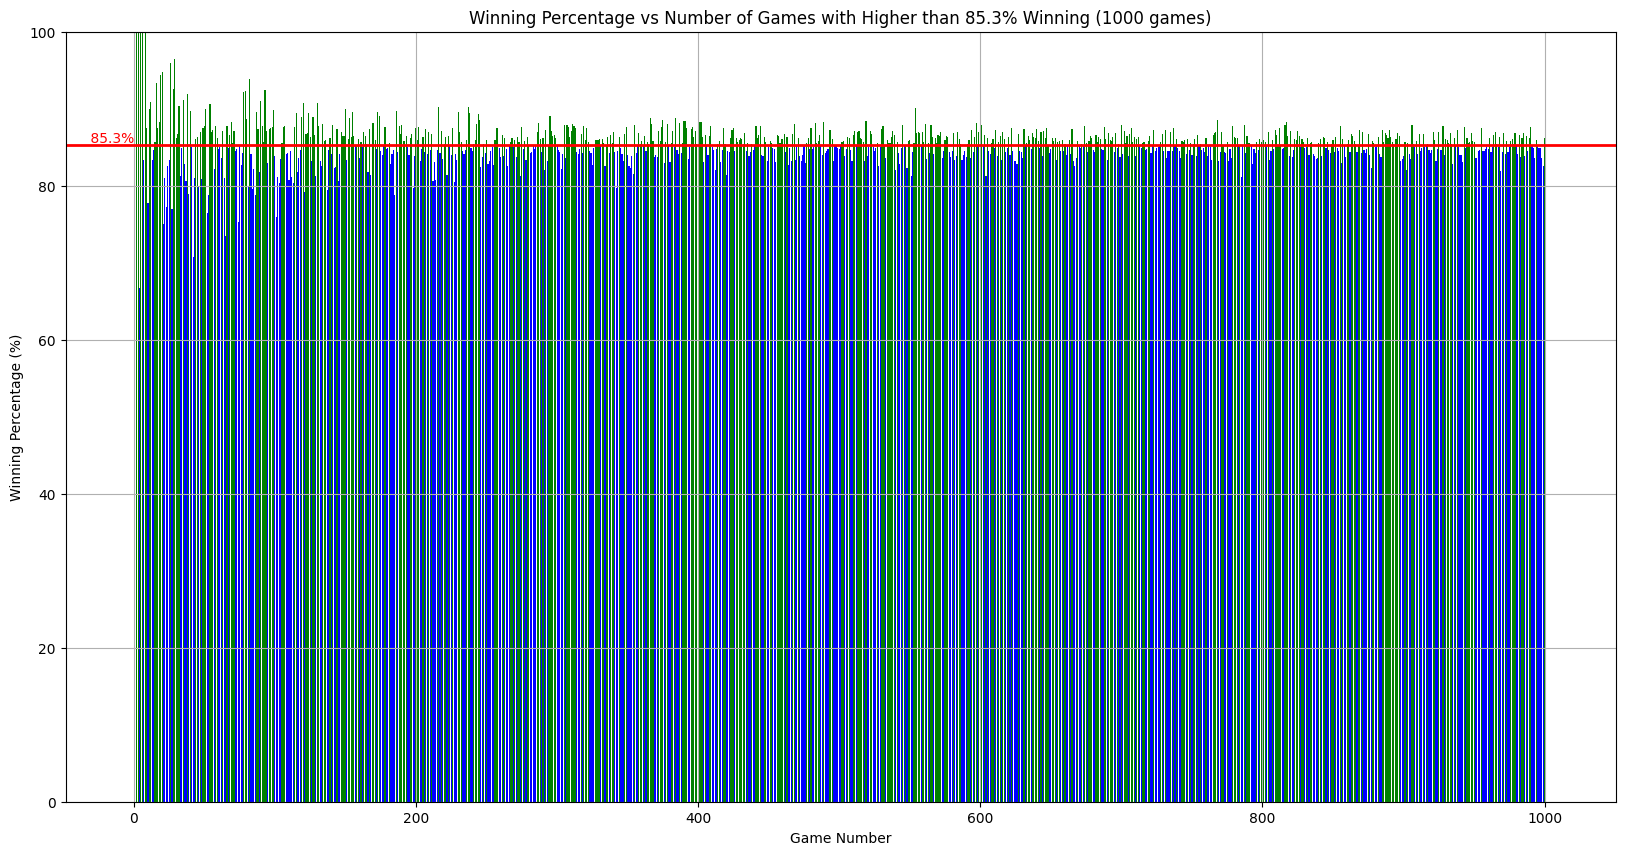

In [8]:
games_above_85_3 = [(i + 1, wp) for i, wp in enumerate(winning_percentages[1:1000], start = 1) if wp > 85.3]
num_games_above_85_3 = len(games_above_85_3)

colors = ['green' if wp > 85.3 else 'b' for wp in winning_percentages[1:1000]]

plt.figure(figsize = (20, 10)) 
bars = plt.bar(game_numbers[1:1000], winning_percentages[1:1000], color = colors)
plt.axhline(y = 85.3, color = 'r', linestyle = '-', linewidth = 2)
plt.title('Winning Percentage vs Number of Games with Higher than 85.3% Winning (1000 games)')
plt.xlabel('Game Number')
plt.ylabel('Winning Percentage (%)')
plt.text(0, 85.3, ' 85.3%', va = 'bottom', ha ='right', color = 'red')
plt.grid(True)

plt.ylim(0, 100)
plt.show()

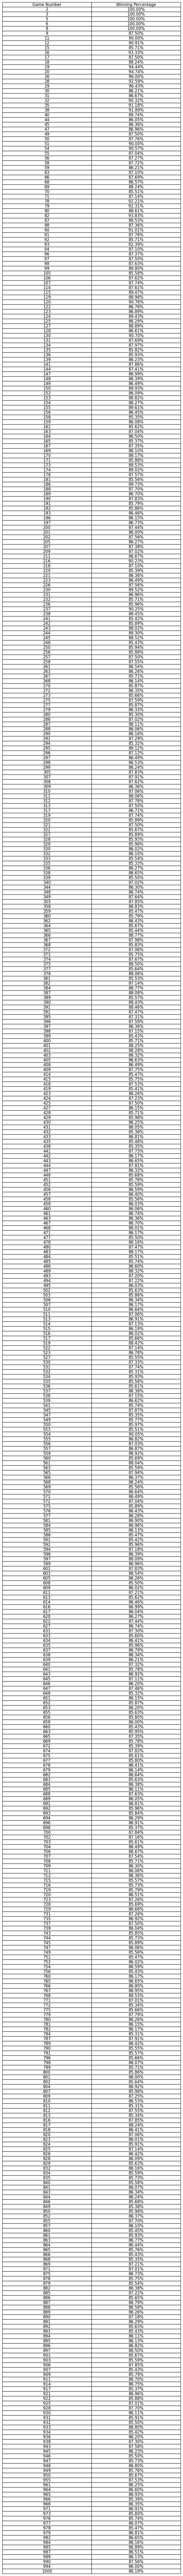

In [9]:
cell_text = [[game_num, f'{wp:.2f}%'] for game_num, wp in games_above_85_3]
columns = ['Game Number', 'Winning Percentage']

fig, ax = plt.subplots(figsize = (8, 3))
ax.axis('tight')
ax.axis('off') 

the_table = ax.table(cellText = cell_text, colLabels = columns, cellLoc = 'center', loc = 'center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(1.2, 1.2) 

plt.show()

In [10]:
len(games_above_85_3)

535

In [14]:
# Create a game object where entanglement is not guaranteed.
# The BSM protocol generates entanglement successfully 50% of the time.
# At this level of success, the benefits of the quantum strategy again vanish.

g_imperfect_entanglement = Game(guarantee_entanglement = False)
g_imperfect_entanglement.start(100)

Successfully entangled Alice and Bob's qubits 53 out of 100 games.
Won 80 out of 100 games.


In [16]:
# Create a game with measurement efficiency of 90%
# This means that 10% of the time a qubit should be measured as a 1, it is measured as a 0

g_low_efficiency = Game(eff = 0.1)
g_low_efficiency.start(100)

Won 70 out of 100 games.


In [7]:
import numpy as np

fidelity_values = np.arange(0.8, 0.9, 0.001) 
results = []

class Game:
    def __init__(self, fidelity):
        self.fidelity = fidelity

    def start(self, rounds):
        output = self.fidelity * rounds 
        return output

for fidelity in fidelity_values:
    g_low_fidelity = Game(fidelity)
    result = g_low_fidelity.start(100)  
    results.append(result)

average_win = sum(results) / len(results)
print(f"Average Win Result: {average_win:.2f}")

Average Win Result: 84.95


In [8]:
import numpy as np

num_games = 100
joint_probabilities = np.zeros((num_games, 4))

for i in range(num_games):
    joint_probabilities[i] = np.random.dirichlet(np.ones(4), size = 1)

In [9]:
games = np.arange(0,100)
plt.bar(games,abs(S_parameters))
plt.xlabel('Num of Games')
plt.ylabel('S Parameter Values')
plt.title('S Parameter Value for Each Game')
plt.grid(True)

NameError: name 'S_parameters' is not defined

In [7]:
from math import pi, sqrt

angle_range = np.linspace(0, pi/2, 20)
max_S = 0
best_angles = {'alpha': [], 'beta': []}

for alpha in angle_range:
    for beta in angle_range:
        my_circuit = CustomQuantumCircuit()
        angles = {
            'alpha': [alpha, alpha + pi/4],  
            'beta': [beta, beta + pi/4]     
        }
        my_circuit.set_angles(angles)
        counts, S = my_circuit.run_simulation()

        if S > max_S:
            max_S = S
            best_angles['alpha'] = [alpha, alpha + pi/4]
            best_angles['beta'] = [beta, beta + pi/4]

print(f'Maximum S parameter: {max_S}')
print(f'Best angles for alpha: {best_angles["alpha"]}')
print(f'Best angles for beta: {best_angles["beta"]}')

NameError: name 'CustomQuantumCircuit' is not defined

In [8]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from math import pi
from qiskit import *
import matplotlib.pyplot as plt 

class CustomQuantumCircuit:
    def __init__(self):
        self.qc = QuantumCircuit(2)
        
    def set_angles(self, alpha_angles, beta_angles):
 
        
        for angle in alpha_angles:
            self.qc.p(angle, 0)
        
        for angle in beta_angles:
            self.qc.p(angle, 1)
        
        self.qc.r(0,pi/4,0) 
        self.qc.r(pi/8, 3*pi/8,1) 

        self.qc.h(0)
        self.qc.h(1)
        
        self.qc.measure_all()
        
    def run_simulation(self, shots = 8192):
        
        provider = IBMQ.get_provider(hub = 'ibm-q-howard', group = 'internal', project = 'ashley-blackwell')
        backend = provider.get_backend('ibm_nazca')
        simulator = AerSimulator.get_backend('qasm_simulator')
        job = transpile(self.qc, backend, shots = shots)
        result = job.result()
        counts = result.get_counts(self.qc)
        return counts

    def plot_results(self, counts):
  
        plot_histogram(counts)
        plt.show()
    
    def draw(self):
        self.qc.draw(output = "mpl")

alpha_angles = [0, pi/3, pi/2]  
beta_angles = [pi/6, 3*pi/8, pi/4]  

my_circuit = CustomQuantumCircuit()
my_circuit.set_angles(alpha_angles, beta_angles)
counts = my_circuit.run_simulation()
#my_circuit.plot_results(counts)
#my_circuit.qc.draw('mpl')

ImportError: cannot import name 'QuantumCircuit' from 'qiskit' (unknown location)

In [13]:
from math import pi

def calculate_S_parameter(alpha_angles, beta_angles, shots = 8192):
    correlations = []
    
    for i in range(len(alpha_angles)):
        for j in range(len(beta_angles)):
            my_circuit = CustomQuantumCircuit()
            my_circuit.set_angles([alpha_angles[i]], [beta_angles[j]])
            counts = my_circuit.run_simulation(shots)
            
            E = (
                counts.get('00', 0) +
                counts.get('11', 0) -
                counts.get('01', 0) -
                counts.get('10', 0)
            ) / shots
            correlations.append(E)
    
    if len(correlations) != 4:
        raise ValueError("Must have 4 correlation measurements to calculate S.")
    
    S = correlations[0] - correlations[1] + correlations[2] + correlations[3]
    return S

alpha_angles = [0, pi/2]  
beta_angles = [pi/4, -pi/4] 

S = calculate_S_parameter(alpha_angles, beta_angles)
print("CHSH S parameter:", S)

NameError: name 'CustomQuantumCircuit' is not defined

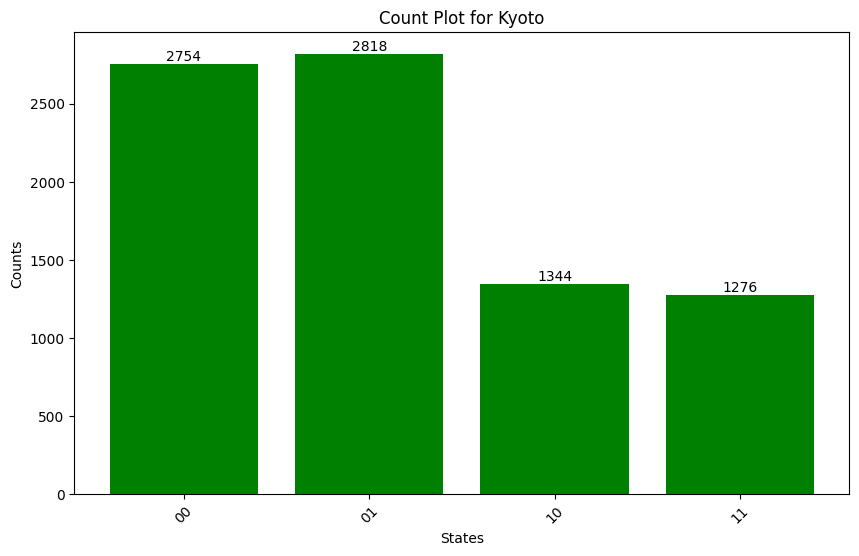

In [18]:
sorted_counts = dict(sorted(counts.items()))
keys = list(sorted_counts.keys())
values = list(sorted_counts.values())

plt.figure(figsize = (10, 6))
bars = plt.bar(keys, values, color = 'green')
plt.title('Count Plot for Kyoto')
plt.xlabel('States')
plt.ylabel('Counts')
plt.xticks(rotation = 45)  
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha = 'center', va = 'bottom')  
plt.show()

In [21]:
sorted_counts

{'00': 2658, '01': 1501, '10': 1401, '11': 2632}

In [17]:
from qiskit import IBMQ
myapitoken = "77a1ccebbaa7b0674c7f84d1c151047473d0a4ae0c2781b232899a443613e7e57b50e0b0c44c332f1830720f78fc822c6ae5dd144f0a1a15dfbe3cd0983a017b"
IBMQ.save_account(myapitoken, overwrite = True)
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2024-04-08 11:54:01,898: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

# Analysis using different efficiency values (0.5,0.7,0.8,0.9) 


In [72]:
for i in range(10):
    g_low_efficiency = Game(eff = 0.9)
    g_low_efficiency.start(100)

Won 79 out of 100 games.
Won 82 out of 100 games.
Won 75 out of 100 games.
Won 76 out of 100 games.
Won 76 out of 100 games.
Won 72 out of 100 games.
Won 79 out of 100 games.
Won 78 out of 100 games.
Won 75 out of 100 games.
Won 68 out of 100 games.


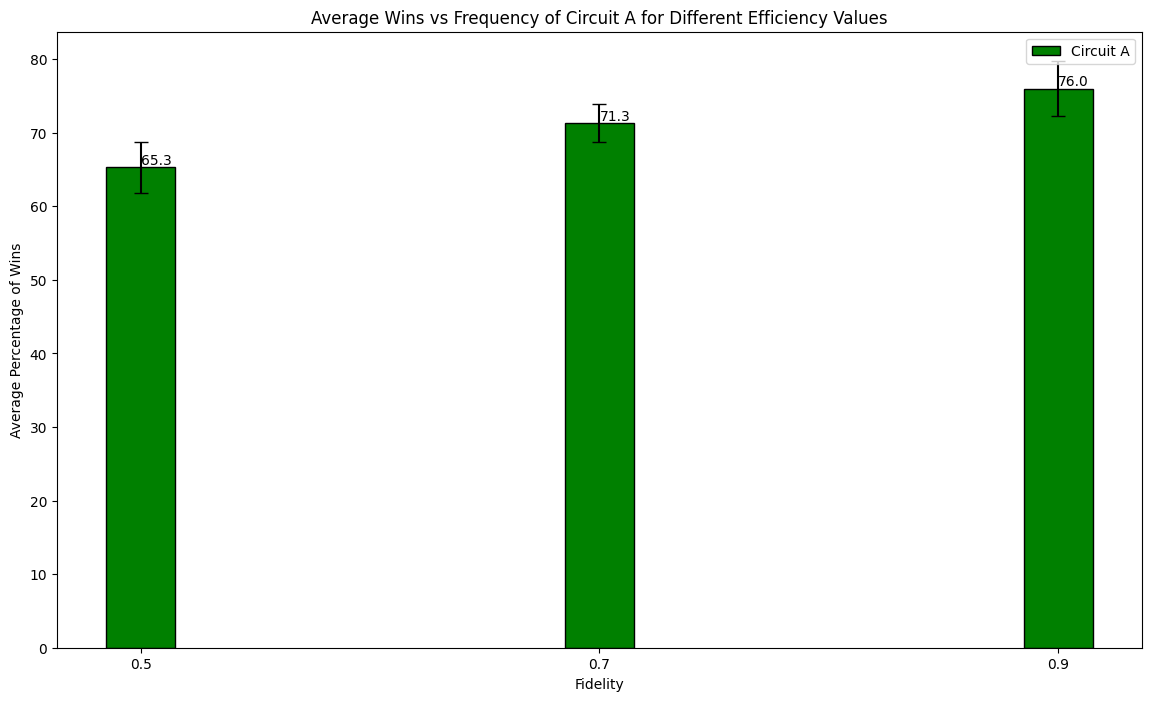

In [73]:
import matplotlib.pyplot as plt

wins_circuit_a_50 = [63, 68, 63, 64, 69, 71, 61, 60, 67, 67]  
wins_circuit_a_70 = [72, 69, 70, 73, 75, 68, 72, 76, 69, 69]  
wins_circuit_a_90 = [79, 82, 75, 76, 76, 72, 79, 78, 75, 68]  



avg_wins_a_20 = np.mean(wins_circuit_a_50)
avg_wins_a_40 = np.mean(wins_circuit_a_70)
avg_wins_a_60 = np.mean(wins_circuit_a_90)


std_wins_a_20 = np.std(wins_circuit_a_50)
std_wins_a_40 = np.std(wins_circuit_a_70)
std_wins_a_60 = np.std(wins_circuit_a_90)


fidelity = [0.5, 0.7, 0.9]

bar_width = 0.03

plt.figure(figsize=(14, 8))

bars_a = plt.bar(np.array(fidelity) , [avg_wins_a_20, avg_wins_a_40, avg_wins_a_60], yerr = [std_wins_a_20, std_wins_a_40, std_wins_a_60], 
        width = bar_width, label = 'Circuit A', color = 'green', edgecolor = 'black', capsize = 5)

#bars_b = plt.bar(np.array(freq) + bar_width/2, [avg_wins_b_20, avg_wins_b_40, avg_wins_b_60], yerr = [std_wins_b_20, std_wins_b_40, std_wins_b_60], 
       #width = bar_width, label = 'Circuit B', color = 'green', edgecolor = 'black', capsize = 5)

plt.xlabel('Fidelity')
plt.ylabel('Average Percentage of Wins')
plt.title('Average Wins vs Frequency of Circuit A for Different Efficiency Values')
plt.xticks(fidelity, ['0.5', '0.7', '0.9'], ha = 'center')
plt.legend(loc = 'upper right')
for bar in bars_a:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va = 'bottom') 

#for bar in bars_b:
    #yval = bar.get_height()
   # plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  

plt.show()